# BITCOIN VOLATILITY

One important characteristic of cryptocurrency that's important to investors and traders is volatility. There are several time series model for predicting it. For the purpose of this project, the **Generalized Autoregressive Conditional Heteroskedasticity (GARCH)** model is utilized to predict the volatility of cryptocurrencies

#### Libraries

In [31]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from config import settings
from data import CryptoCompareAPI, SQLRespository

### Prepare Data

In [32]:
ticker = "BTC"
n_records = 2000

# Instantiate the sqlite conection
connection = sqlite3.connect(database=settings.db_name, check_same_thread=False)
repo = SQLRespository(connection=connection)


# You can other cryptocurrency by uncommenting the below lines of code and changing the ticker . 
# Check https://min-api.cryptocompare.com documentation


# crypto = CryptoCompareAPI()
# records = crypto.getCoinPrice(ticker=ticker, n_records=n_records)
# repo.insert_table(table_name=ticker, records=records)

In [33]:
df = repo.read_table(table_name=ticker)
df

,low,high,open,close
date,,,,
2019-07-09,12117.31,12808.06,12296.16,12567.02
2019-07-10,11569.94,13183.73,12567.02,12099.12
2019-07-11,11002.39,12099.91,12099.12,11343.12
2019-07-12,11096.61,11931.91,11343.12,11797.37
2019-07-13,10827.53,11835.87,11797.37,11363.97
...,...,...,...,...
2024-12-25,97568.85,99484.75,98606.93,99356.06
2024-12-26,95098.08,99888.75,99356.06,95680.19
2024-12-27,93270.34,97351.17,95680.19,94170.09


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2001 entries, 2019-07-09 to 2024-12-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   low     2001 non-null   float64
 1   high    2001 non-null   float64
 2   open    2001 non-null   float64
 3   close   2001 non-null   float64
dtypes: float64(4)
memory usage: 78.2 KB


Cryptocurrencies function much like traditional financial markets: people buy and sell tokens or coins. The prices of these assets can rise or fall depending on factors such as supply, demand, market sentiment, or broader economic events. In the world of cryptocurrencies, the goods being traded are digital assets (often called tokens or coins), representing value or utility on a blockchain.

Throughout each trading day, the price of a cryptocurrency can fluctuate significantly. To analyze its performance, we focus on four key metrics: open, high, low, close, and volume.  
- **Open** is the price of the cryptocurrency at the start of the trading day.  
- **Close** is the price when trading ends for the day.  
- **High** and **low** represent the highest and lowest prices that the cryptocurrency reached during the day.  
- **Volume** is the total number of coins or tokens traded within the specified timeframe.  

Generally, cryptocurrencies with higher trading volumes tend to experience greater price movements due to increased activity and liquidity, whereas lower volume assets may remain relatively stable or illiquid.

### Explore

Let’s explore how the price of Bitcoin (or any other cryptocurrency) has changed over the last decade. 

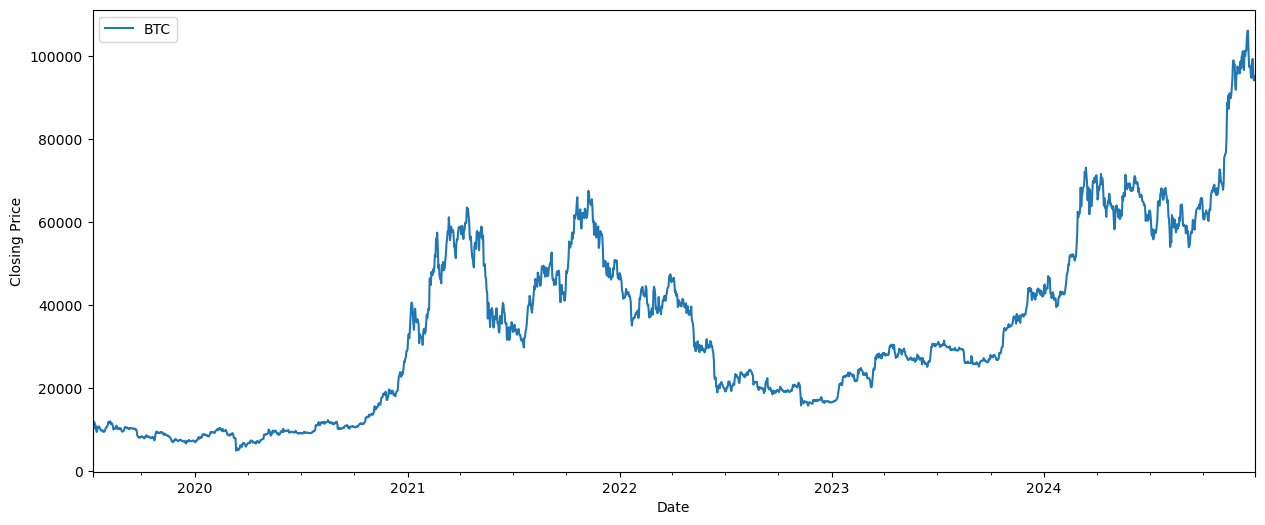

In [35]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot closing price of BTC
df["close"].plot(ax=ax, label="BTC")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()

One factor investors and traders compare cryptocurrency is by their `returns`. A return is change in value of an investment represented by percentage. Let's look at the daily returns of **BTC**

**Tip:** The Dataframe is already sorted in ascending order which is crucial. Becuase in order to calculate daily `returns`, we calculate the change in a particular day closing price of an investement (coin) to the closing price of  its previous day.

Pandas has made that easier using the `pct_change`methos

In [36]:
# Create return column
df["return"] = df["close"].pct_change()
df

,low,high,open,close,return
date,,,,,
2019-07-09,12117.31,12808.06,12296.16,12567.02,NaN
2019-07-10,11569.94,13183.73,12567.02,12099.12,-0.037232
2019-07-11,11002.39,12099.91,12099.12,11343.12,-0.062484
2019-07-12,11096.61,11931.91,11343.12,11797.37,0.040046
2019-07-13,10827.53,11835.87,11797.37,11363.97,-0.036737
...,...,...,...,...,...
2024-12-25,97568.85,99484.75,98606.93,99356.06,0.007597
2024-12-26,95098.08,99888.75,99356.06,95680.19,-0.036997
2024-12-27,93270.34,97351.17,95680.19,94170.09,-0.015783


Now let's plot the return of BTC

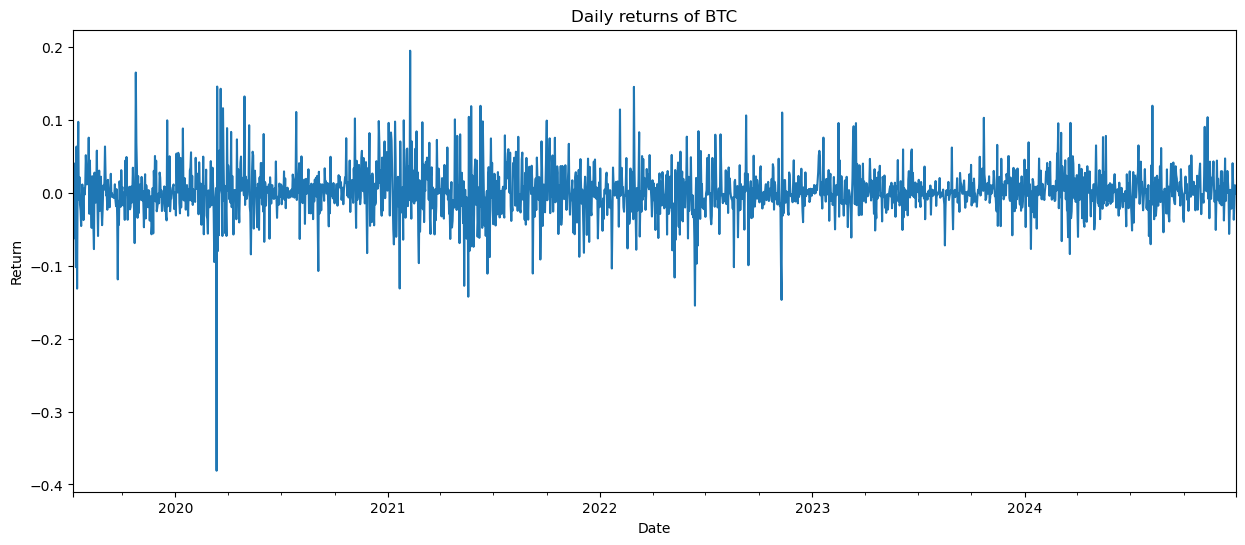

In [37]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns of BTC
df["return"].plot(ax=ax)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Daily returns of BTC");

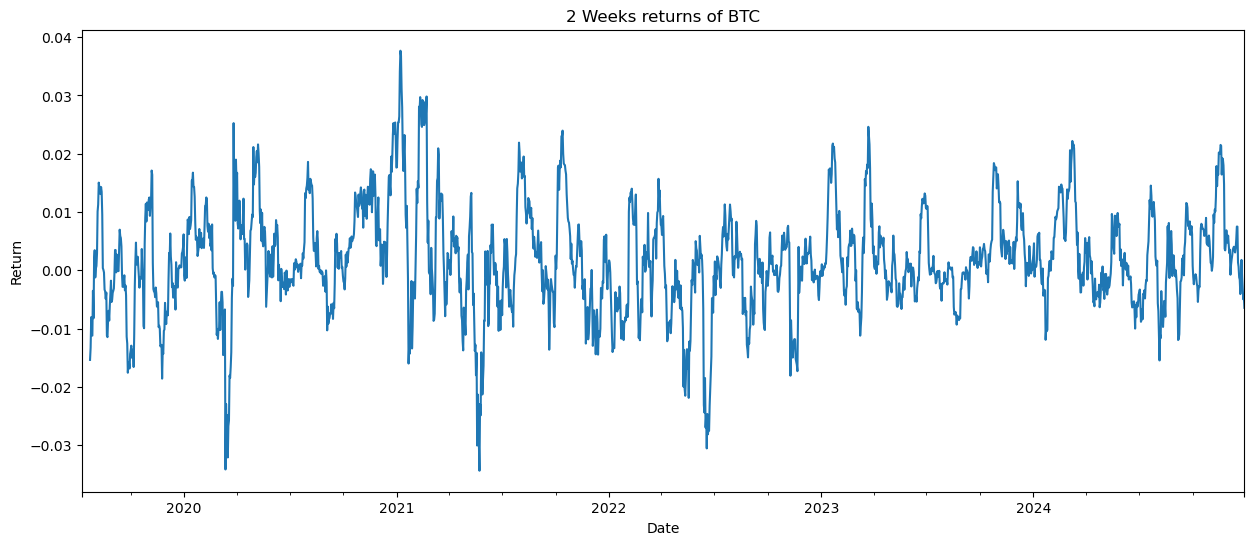

In [38]:
# Let make the plot look smoother using rolling window of 14 days
fig, ax = plt.subplots(figsize=(15, 6))

df["return"].rolling(14).mean().plot(ax=ax)
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("2 Weeks returns of BTC");

Another name for day-to-day flunctuation in returns is called __volatility__ which is also an important factor for an investor.

In [39]:
# Series of retunrs
y = df["return"].dropna()
y

date
2019-07-10   -0.037232
2019-07-11   -0.062484
2019-07-12    0.040046
2019-07-13   -0.036737
2019-07-14   -0.102038
                ...   
2024-12-25    0.007597
2024-12-26   -0.036997
2024-12-27   -0.015783
2024-12-28    0.010301
2024-12-29   -0.001265
Name: return, Length: 2000, dtype: float64

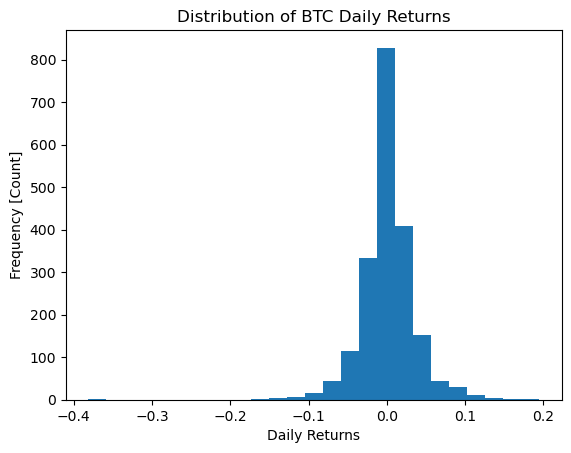

In [40]:
# Create an histogram of `retunns`
plt.hist(y, bins=25)

# Axis label
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [Count]")
plt.title("Distribution of BTC Daily Returns");

It turns out that returns follow an almost normal distribution, centered around `0`. __Volatility__ is the measure of the spread of these returns around the mean. In other word, volatility in finance is same as standard deviation in statistics.

Let's calculate the standard deviation of the returns.

In [41]:
btc_daily_volatility = y.std()
print(f"BTC Daily Volatility: {btc_daily_volatility}")

BTC Daily Volatility: 0.03409800601418527


While daily volatility is inportant, investors are also interested in volatility over other time periods -- like annual volatility. To better put it crypto traders are mostly interested in daily volatility, while most investors are interested in annual volatility as they will be holding for a long time.

In order to calculate the annual volatility, we multiply the daily volatility by the square of the the numbers of trading days in a year. Unlike the stocks markets that close on weekends and closes on days international holidays are been observed, the crypto market does't have a break.

In [42]:
btc_annual_volatility = btc_daily_volatility * np.sqrt(365)
print(f"BTC Annual Volatility: {btc_annual_volatility}")

BTC Annual Volatility: 0.6514414902064086


Also, annual volatility is typically larger than daily volatility because volatility scales with the square root of time. This happens because, over time, the effects of small daily fluctuations compound, leading to a higher aggregate measure of variability.

Since this is a time series data, another way to look at volatility is by calculating it using a rolling window.

In [43]:
btc_rolling_50d_volatility = y.rolling(window=50).std().dropna()
btc_rolling_50d_volatility.head()

date
2019-08-28    0.043209
2019-08-29    0.043039
2019-08-30    0.042239
2019-08-31    0.041804
2019-09-01    0.041596
Name: return, dtype: float64

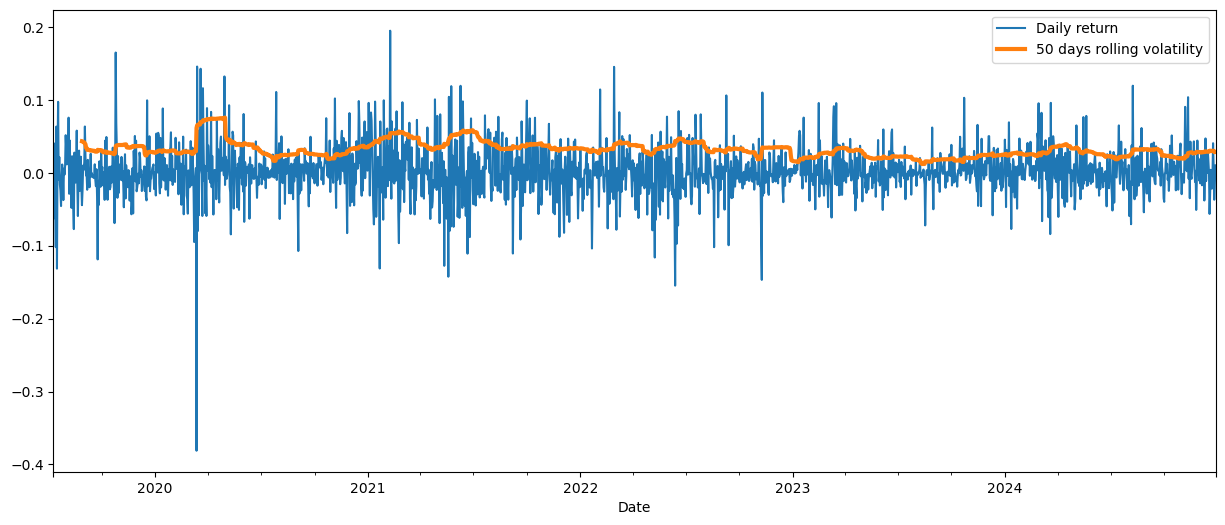

In [44]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot BTC daily return
y.plot(ax=ax, label="Daily return")
# Plot BTC 50 days rolling volatility
btc_rolling_50d_volatility.plot(ax=ax, label="50 days rolling volatility", linewidth=3)
plt.xlabel("Date")

plt.legend();

Here volatility goes up when the returns change drastically -- either up mor down. For instance in the above plot, we can see big increase in volatility in March, 2020 when there where several large negative returns.

This plot reveals a problem. We want to use returns to see if high volatility on one day is associated with high volatility on the following day. But high volatility is caused by large changes in returns, which can either be positive or negative. How can we assess negative and positive values together without them canceling each other out? One solution is to take the absolute value of the numbers, which is what is used to calculate performance metrics like mean absolute error. The other solution, which is more common, is to square all the values.

Text(0.5, 1.0, 'Square Returns')

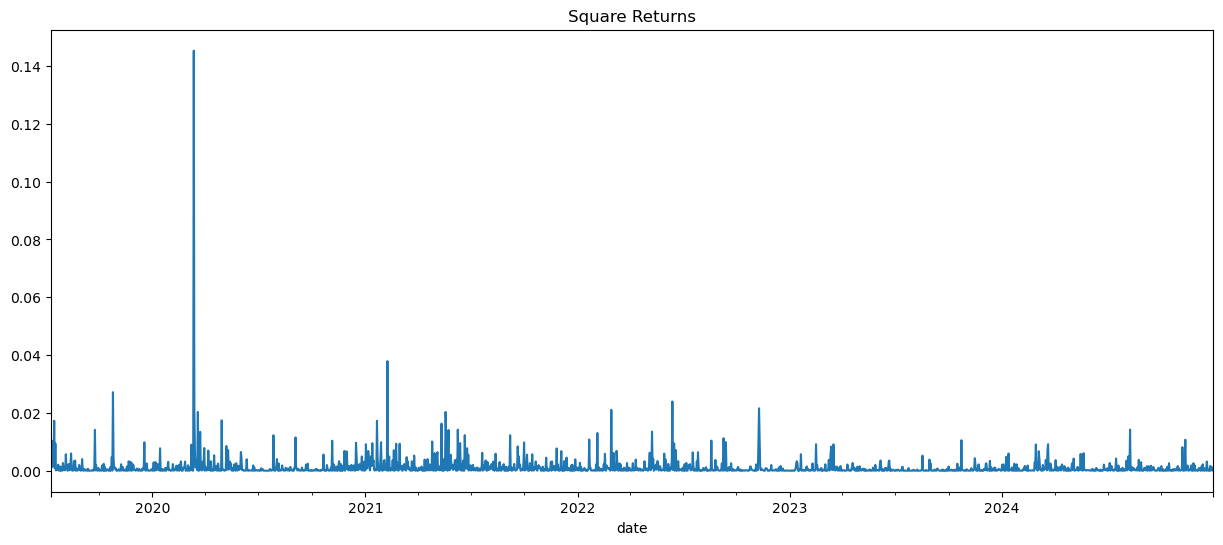

In [45]:
# A time series plot of the squared returns
fig, ax = plt.subplots(figsize=(15, 6))
(y**2).plot(ax=ax)
plt.title("Square Returns")

**Explanation**:
- With the squared returns plot its easier to see periods of high and low volatility
- High volatility days tend to cluster together. This is a perfect situation to use GARCH model.

A GARCH model is like ARMA model. It has `p` parameter handling correlation at prior steps and a `q` parameter for dealing with "shock" events. It also uses the notion of lag. To see how many lags we should have in the model, an ACF nad PACF plot is the right plot -- but using the squared returns

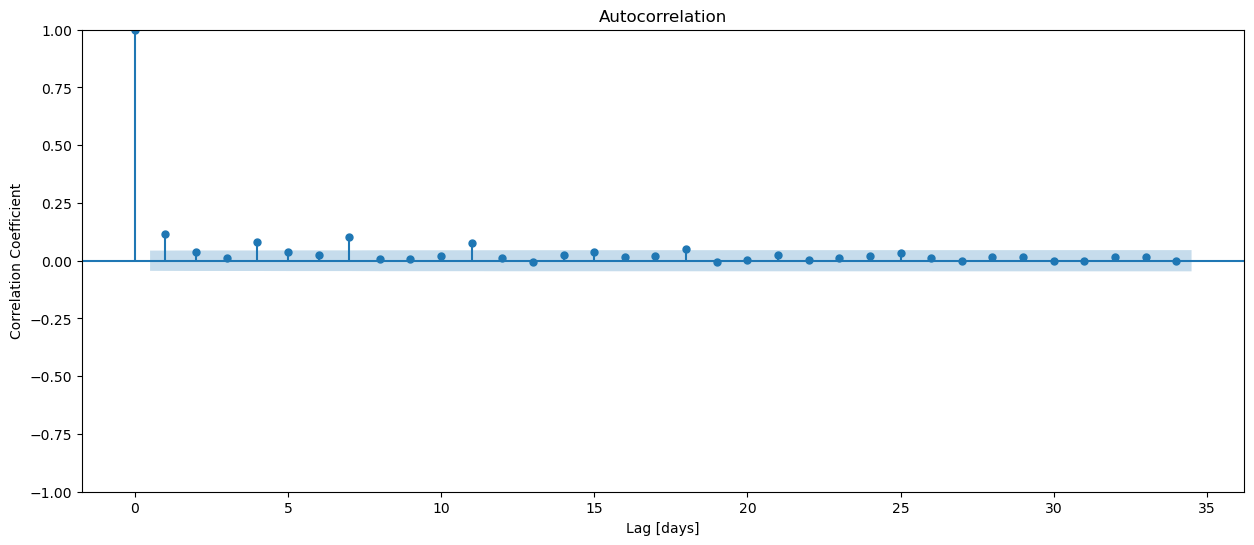

In [46]:
fig, ax = plt.subplots(figsize=(15, 6))

# ACF plot of the squared returns
plot_acf(x=y**2, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

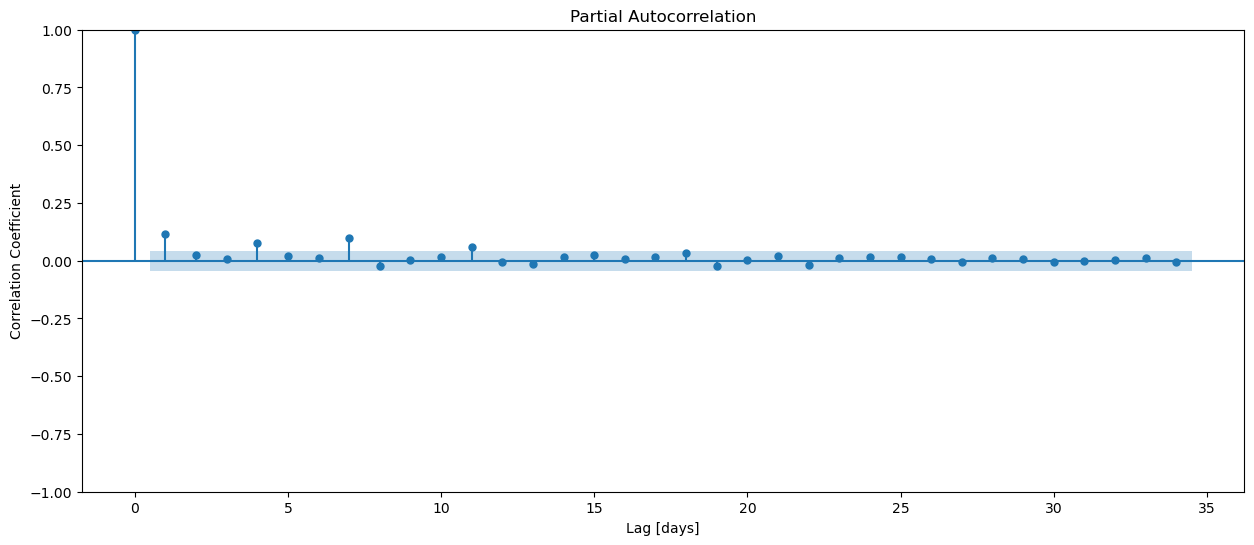

In [47]:
fig, ax = plt.subplots(figsize=(15, 6))

# PACF plot of the squared returns
plot_pacf(x=y**2, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

**Observations**:
- Based on the PACF plot, **lag 1** is the best lag to use because it is the only lag with a significant partial autocorrelation.
- The PACF plot shows a significant value at **lag 1**, meaning there is some dependence of today's BTC returns on yesterday's returns. 
- However, this effect appears to diminish quickly, as other lags fall within the confidence interval bands, suggesting little to no partial autocorrelation beyond lag 1.

**Implications for BTC Returns**:
- Financial time series, such as daily returns of BTC, often exhibit **weak autocorrelation** because they tend to follow a random walk or are influenced by noise.
- The lack of significant lags beyond lag 1 aligns with the Efficient Market Hypothesis (EMH), which suggests that past price movements or returns have limited predictive power for future movements.


### Split

**Returns** will be used to train the model, but we want it to predict **volatility**. if a test set is created, it wouldn't give us the "true values" the would be needed to assess the model performance. 

In [48]:
cutoff_test = int(len(y) * 0.8)
y_train = y.iloc[:cutoff_test]
print("y_train type: ", type(y_train))
print("y_train Shape: ", y_train.shape)
y_train.tail()

y_train type:  <class 'pandas.core.series.Series'>
y_train Shape:  (1600,)


date
2023-11-21   -0.045840
2023-11-22    0.046575
2023-11-23   -0.003341
2023-11-24    0.011739
2023-11-25    0.001719
Name: return, dtype: float64

### Build Model

Build a GARCH model using the data in y_train starting with `1` as the value for `p` and `q`. Then we use thr model summary to assess it's performance and try other lags.

In [49]:
# Build model and train
model = arch_model(
    y_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)

print("Model type: ", type(model))
model.summary()

Model type:  <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3136.43
Distribution:                  Normal   AIC:                          -6264.85
Method:            Maximum Likelihood   BIC:                          -6243.34
                                        No. Observations:                 1600
Date:                Mon, Dec 30 2024   Df Residuals:                     1599
Time:                        08:27:00   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.9383e-03  8.792e-04      2.204  2.749e-02 [2.150e-04,3.662e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5284e-05  2.277e-06     11.105  1.188e-28 [2.082e-05,2.975e-05]
alpha[1]       0.0510  2.804e-02      1.818  6.904e-02  [-3.977e-03,  0.106]
beta[1]        0.9290  2.154e-02     43.128      0.000     [  0.887,  0.971]
============================================================================

Covariance estimator: robust
"""

A time series plot of BTC returns and conditional volatility of the `model`.

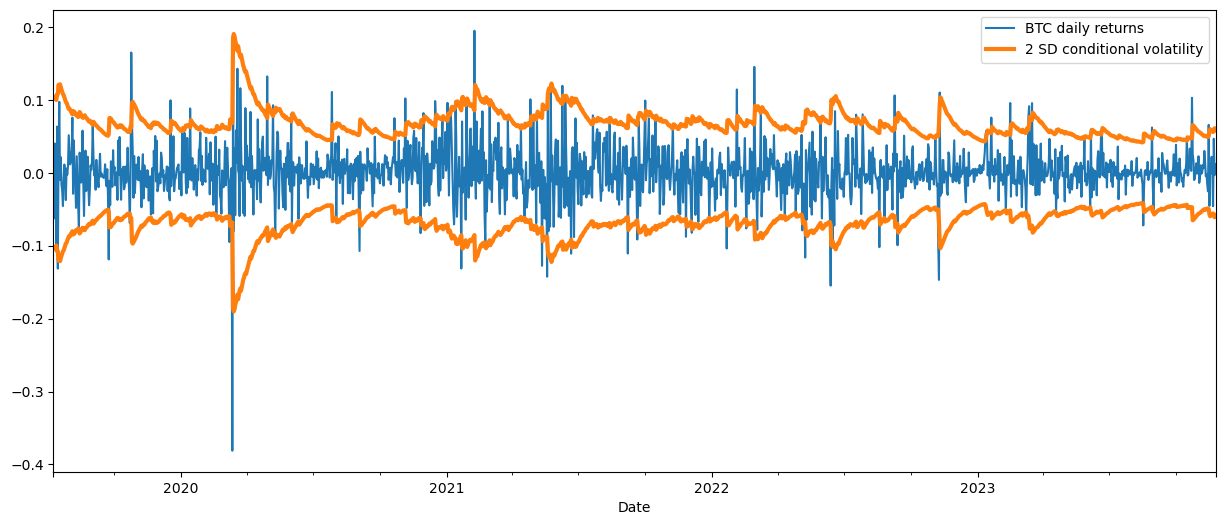

In [50]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot of y_train
y_train.plot(ax=ax, label="BTC daily returns")

# Plot of conditional volatility * 2
(model.conditional_volatility * 2).plot(ax=ax, color="C1", label="2 SD conditional volatility", linewidth="3")

# Plot of conditional volatility * -02
((model.conditional_volatility.rename()) * -2).plot(ax=ax, color="C1", linewidth="3")

# Axis label
plt.xlabel("Date")

# Add legend
plt.legend();

Visually, the model looks good, but we should examine residuals. In the case of GARCH model we look at standardized residuals.

Time series plot of the `model` standardized residuals

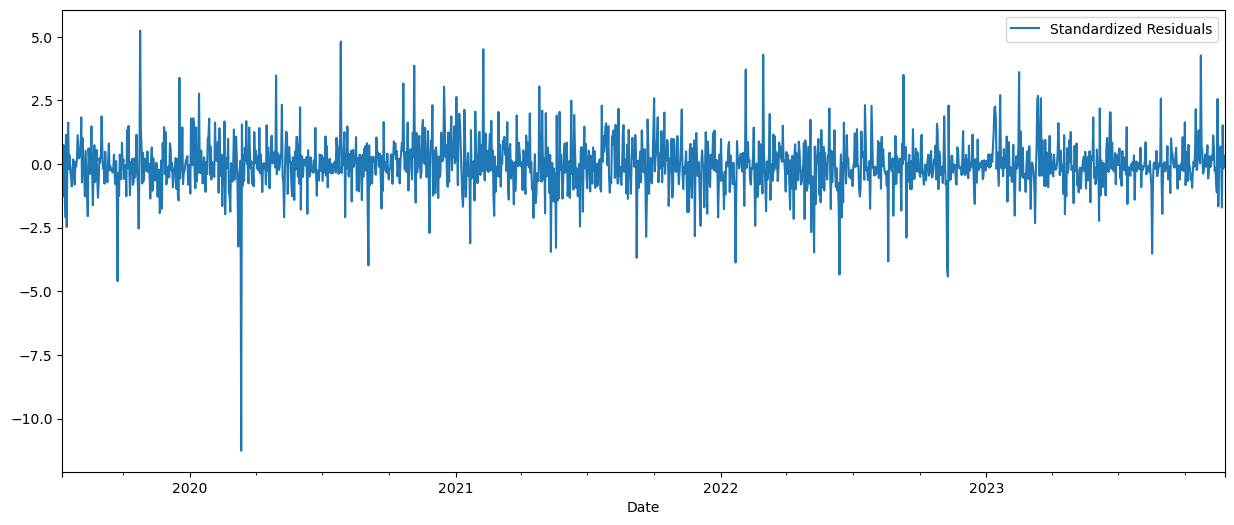

In [51]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot of residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Axis label
plt.xlabel("Date")

# Add legend
plt.legend();

A residual plot look good: they have consistent mean and spread over time. Lets check their normality using histogram.

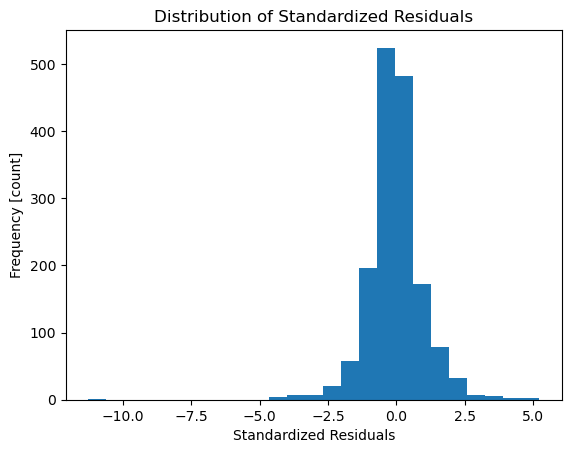

In [52]:
# Create histogram od standardized residuals
plt.hist(model.std_resid, bins=25)

# Axis labels
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency [count]")

# Add title
plt.title("Distribution of Standardized Residuals");

Final visualization is the ACF plot of the rresiduals. Just like we did previously, the values need to be squared

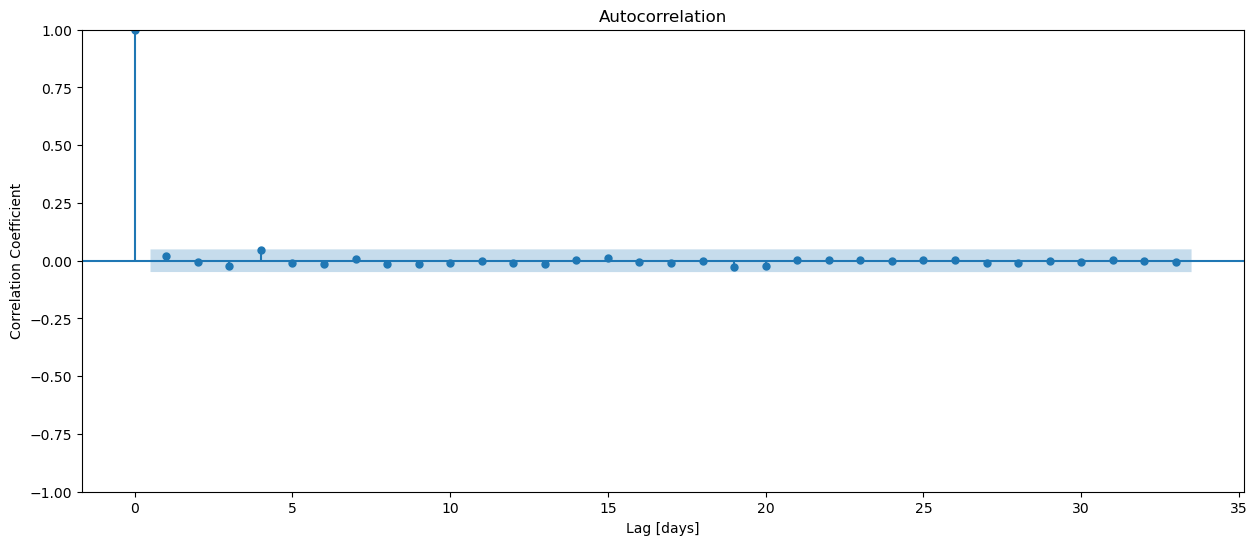

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))

# ACF plot of the squared returns
plot_acf(x=model.std_resid**2, ax=ax)
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

The model is ready for final evaluation

### Evaluate

To evaluate we use walk forward validation. Before we do, let's look at how the model returns it prediction

In [54]:
y_train.tail(1)

date
2023-11-25    0.001719
Name: return, dtype: float64

In [55]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance
print("one_day_forecast type: ", type(one_day_forecast))
one_day_forecast

one_day_forecast type:  <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2023-11-25,0.000823


There are two things here. First the model forecast shows the predicted **variance**, not the **standard deviation/volatility**. So we need to take the square root of the value. Second, the prediction is in form of  Dataframe in the `h.1` column which is the prediction of the following day. 

In [56]:
np.sqrt(one_day_forecast.iloc[0,0]).round(4)

0.0287

### Iterate

Walk-forward validation on the model

In [57]:
# A list to hold predictions
predictions = []

# Size of the test data (20%)
test_size = int(len(y) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y.iloc[:-(test_size - i)]
    
    # Train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)
    
    # Generate next prediction (volatility not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5
    
    # Append prediction to list
    predictions.append(next_pred)
    

# Series of prediction list
y_test_wfv = pd.Series(predictions, index=y.tail(test_size).index)

print("y_test_wfv type: ", type(y_test_wfv))
print("y_test_wfv shape: ", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type:  <class 'pandas.core.series.Series'>
y_test_wfv shape:  (400,)


date
2023-11-26    0.028686
2023-11-27    0.028195
2023-11-28    0.027752
2023-11-29    0.027477
2023-11-30    0.026782
dtype: float64

In [58]:
y_test_wfv.tail()

date
2024-12-25    0.028516
2024-12-26    0.027875
2024-12-27    0.028621
2024-12-28    0.028452
2024-12-29    0.028009
dtype: float64

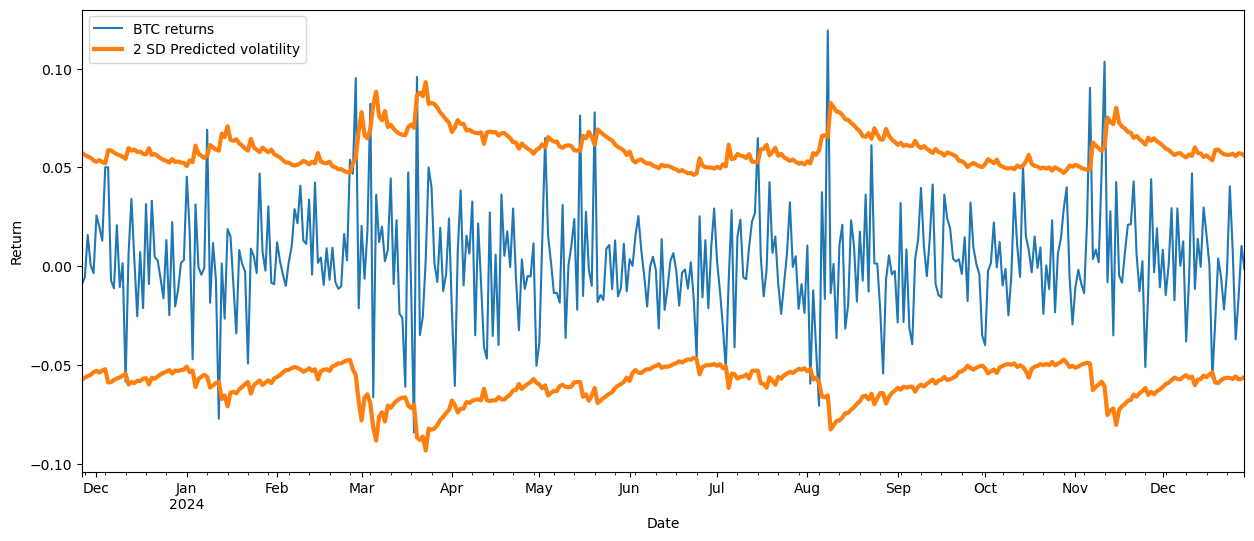

In [59]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot of rerturns of test data
y.tail(test_size).plot(ax=ax, label="BTC returns")

# Plot of volatility predictions * 2
(y_test_wfv * 2).plot(ax=ax, color="C1", label="2 SD Predicted volatility", linewidth="3")

# Plot of volatility predictions * -2
((y_test_wfv) * -2).plot(ax=ax, color="C1", linewidth="3")

# Axis label
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

## Results

The result is just predictions for some days. But we need to format the data in a way that a third party can use it easily. The `prediction_index` of 5 dates needs to be in ISO 8601 format.

In [60]:
# Generate 5 days volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5

# Calculate forecast start date
start = prediction.index[0] + pd.DateOffset(days=1)

# Create Date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

# Create prediction index label, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

# Extract prediction from Dataframe and get square root
data = prediction.values.flatten()

# Combine data and prediction_index into Series
prediction_formatted = pd.Series(data=data, index=prediction_index)
print(prediction_formatted)
# Print dictionary
print(prediction_formatted.to_dict())

2024-12-30T00:00:00    0.028009
2024-12-31T00:00:00    0.028156
2025-01-01T00:00:00    0.028299
2025-01-02T00:00:00    0.028438
2025-01-03T00:00:00    0.028574
dtype: float64
{'2024-12-30T00:00:00': 0.02800901812724608, '2024-12-31T00:00:00': 0.028155705458543505, '2025-01-01T00:00:00': 0.02829872149020943, '2025-01-02T00:00:00': 0.028438179546865183, '2025-01-03T00:00:00': 0.028574188229887373}
